<a id='top'></a>
# Table of Contents
[Introduction](#introduction)
- [Context](#context)
- [My Hypotheses](#my-hypotheses)
- [More open-ended questions to explore](#more-openended-questions)

[Import](#import)

- [Load salary data into pandas](#load-salary-data)
- [Data pipeline](#data-pipeline)
- [Spot Checking the Data](#spot-checking-the)
- [Measuring the Distribution of Salaries](#measuring-the-distribution)
- [Plotting the League's Average Distribution Over Time](#plotting-the-leagues)
- [Relating Wins to Distribution of Salaries](#relating-wins-to)
- [Correlation of Win Percentage and Relative Standard Deviation](#correlation-of-win)
    - [Observed Data](#observed-data)
    - [Random Data](#random-data)
- [Further Exploration](#further-exploration)
- [Correlation Conclusions](#correlation-conclusions)
- [Measuring Correlation Over Time](#measuring-correlation-over)

[Conclusions](#conclusions)
- [Results](#results)
- [Suggestions for future direction](#suggestions-for-future)
- [What I would do differently](#what-i-would)

[Appendix](#appendix)
- [Data sources](#data-sources)
- [Git history](#git-history)

<a id='introduction'></a>
# Introduction [top](#top)

<a id='context'></a>
### Context [top](#top)
By 2010 Lebron James was considered by many the best basketball player in the NBA and a once-in-a-lifetime talent. Time since 2010 has affirmed these judgements. 2010 is special because that is the year he infamously declared he ["would take his talents to South Beach and join the Miami Heat."](https://www.youtube.com/watch?v=RTeCc8jy7FI). As a free-agent he was able to sign a new contract with any team. He joined other superstar free-agents Dwayne Wade and Chris Bosh to form what is now known as "The Big 3."

This moment was special not only because these 3 players were so good, but because normally the salary cap prohibits too many stars accumulating on one team. Not only did these 3 players all take less money than they could get elsewhere, but Miami was able to get rid of their bad contracts from the previous year. This was a rare opportunity.

While this strategy saw succes, with Miami winning 2 championships before Lebron left in 2015, it was not without drawbacks. Outside of the big 3 the heat had a few decent players, and some other one-dimensional players. These one-dimensional players only contributed to 3-point shooting, or defense, etc. In other words, this very succesful team had lots of bad players.

Other teams emulated this model such as Brooklyn in '14 with Kevin Garnet, Paul Peirce , Deron William, and Joe Johnson, who did very poorly. We also saw the same dynamic (probably even morese) in Cleveland when Lebron returned there after leaving Miami.

<a id='my-hypotheses'></a>
### My hypotheses [top](#top)

- Team's salaries are more unevenly distributed in 2021 than the mid 90's (when I started folliwing the NBA). ([Jump to results](#plotting-the-leagues))
    - This trend coincides with Lebron's move to Miami in 2011 ([Jump to results](#plotting-the-leagues))

<a id='more-openended-questions'></a>
### More open-ended questions to explore [top](#top)
- Does this strategy work? If this is truly a trend, one simple explanation is that it's effective. ([Jump to results](#correlation-conclusions))
    - Has this strategy's effectiveness been consistent or changed over time? ([Jump to results](#measuring-correlation-over))
- Do some of the historically signifant teams share similarities in their distribution of salaries? ([Jump to results](#spot-checking-conclusions))

<a id='import'></a>
# Import [top](#top)
All imports for the notebook are handled here.

In [8]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
import datetime as dt
from scipy.stats import variation
from scipy.stats import shapiro
from scipy.stats import pearsonr
from scipy.stats import truncnorm
from scipy.stats import linregress
import matplotlib.pyplot as plt
import random
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

<a id='load-salary-data'></a>
# Load salary data into pandas [top](#top)

In [13]:
def loadData():
    with open('data/nbaSalaryData.json', 'r') as fp:
        return json.load(fp)

In [14]:
nbaSalaryData = loadData()
        
df = pd.Series({
    (i,j,m): nbaSalaryData[i][j][k][m]
    for i in nbaSalaryData
    for j in nbaSalaryData[i]
    for k in ['players']
    for m in nbaSalaryData[i][j][k]
}).to_frame('salary').rename_axis('year team player'.split())
df

salary
year      team      player                      
1990-1991 Cleveland Hot Rod Williams  $3,785,000
                    Danny Ferry       $2,640,000
                    Mark Price        $1,400,000
                    Brad Daugherty    $1,320,000
                    Larry Nance       $1,260,000
...                                          ...
2020-2021 New York  Ignas Brazdeikis  $1,517,981
                    Wayne Ellington   $1,000,000
                    Taj Gibson        $1,000,000
                    Jared Harper         $79,568
                    Andrew White         $25,000

[14446 rows x 1 columns]

<a id='data-pipeline'></a>
# Data Pipeline [top](#top)
Before we can explore our results we need to take our pandas dataframe to validate our data, clean it, get the relative standard deviation from the salaries, and add the win percentages from `standings.json`. This workflow was inspired by a talk I watched by [Vincent D. Warmerdam's at PyData in 2019](https://www.youtube.com/watch?v=yXGCKqo5cEY) entitled *Untitled12.ipynb*.

In [42]:
def log(f):
    def wrapper(df, *args, **kwargs):
        start = dt.datetime.now()
        result = f(df, *args, **kwargs)
        stop = dt.datetime.now()
        print(f'{f.__name__}:\n  runtime={stop - start}, end shape={result.shape}')
        return result
    return wrapper

@log
def startPipeline(df):
    return df.copy()

@log
def clean(df):
    # replace empty str with null and remove null
    df.replace('', np.nan, inplace=True)
    df.dropna(inplace=True)    
    # convert salary str to float
    df = df.replace('[\$,]','',regex=True).astype(float)
    return df

@log
def transform(df):
    df = (df.groupby(["year", "team"])
           .apply(variation)
           .astype(float)
           .to_frame()
           .rename(columns={0:'salary rsd'}))
    return df

@log
def add(df):
    nbaSalaryData = loadData()
    data = []
    for year in nbaSalaryData.keys():
        for team in nbaSalaryData[year]:
            data.append((year, team, nbaSalaryData[year][team]['winPct']))
    dfTemp = (pd.DataFrame(data, columns=["year", "team", "win percentage"])
     .set_index(["year", "team"])
     .sort_index())
    df["win percentage"] = dfTemp.values
    return df
    

@log 
def removeOutliers(df):
    return df

df_processed = (df
 .pipe(startPipeline)
 .pipe(clean)
 .pipe(transform)
 .pipe(add)
 .pipe(removeOutliers))
df_processed

startPipeline:
  runtime=0:00:00, end shape=(14446, 1)
clean:
  runtime=0:00:00.037007, end shape=(14418, 1)
transform:
  runtime=0:00:00.120959, end shape=(906, 1)
add:
  runtime=0:00:00.015041, end shape=(906, 2)
removeOutliers:
  runtime=0:00:00, end shape=(906, 2)


salary rsd  win percentage
year      team                                   
1990-1991 Atlanta        0.716301           0.524
          Boston         0.817674           0.683
          Brooklyn       0.709815           0.317
          Charlotte      0.612866           0.317
          Chicago        0.722554           0.744
...                           ...             ...
2020-2021 Sacramento     1.110634           0.429
          San Antonio    1.041250           0.333
          Toronto        1.338505           0.167
          Utah           1.177966           0.667
          Washington     1.400230           0.286

[906 rows x 2 columns]

<a id='spot-checking-the'></a>
## Spot Checking the Data [top](#top)
Before looking at the data as a whole I will spot-check a few notable teams that I'm familiar with and see how they compare.

First, I want to look at the team that largely inspired this question: the 2011-2012 Miami Heat with the Big 3 (Lebron, Chris Bosh, and Dwayne Wade). Other notable teams are the 1992-1993 Chicago Bulls (final year of Michael Jordan's first 3-peat) and the 2015-2016 Golden State Warriors (record for most wins in a season), and the 2019-2020 LA Lakers (the most recent NBA champions).

We want to use our unprocessed dataframe (because that it has the players) but will still need to clean the data. We can use the same process as above.

In [32]:
df_players = (df
 .pipe(startPipeline)
 .pipe(clean))

df_players

startPipeline:
  runtime=0:00:00.000999, end shape=(14446, 1)
clean:
  runtime=0:00:00.045002, end shape=(14418, 1)


salary
year      team      player                     
1990-1991 Cleveland Hot Rod Williams  3785000.0
                    Danny Ferry       2640000.0
                    Mark Price        1400000.0
                    Brad Daugherty    1320000.0
                    Larry Nance       1260000.0
...                                         ...
2020-2021 New York  Ignas Brazdeikis  1517981.0
                    Wayne Ellington   1000000.0
                    Taj Gibson        1000000.0
                    Jared Harper        79568.0
                    Andrew White        25000.0

[14418 rows x 1 columns]

In [33]:
def playersAndSalaries(year, team):
    temp = df_players.loc[(year, team)]
    players = temp.index.values
    salaries = temp["salary"].replace('[\$,]','',regex=True).astype(float).tolist()
    # sort salaries in ascending and mirror changes in labels
    salaries, players = zip(*sorted(zip(salaries, players), reverse=True))
    return list(players), list(salaries)

def plotTeamSalaries(year, team):
    labels, salaries = playersAndSalaries(year, team)
    
    print(f"{team}, {year}, {variation(salaries)}")
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.pie(salaries, labels=labels)
    plt.show()

Chicago, 1992-1993, 0.8904381641077361


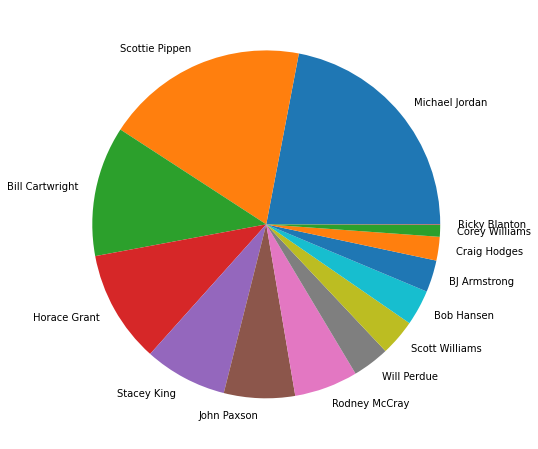

In [34]:
plotTeamSalaries("1992-1993", "Chicago")

Miami, 2010-2011, 1.342881292618329


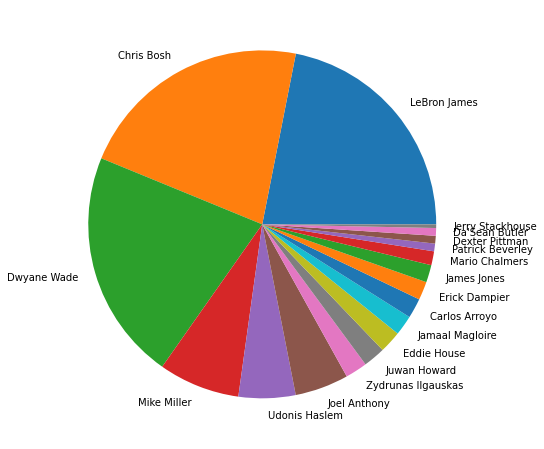

In [35]:
plotTeamSalaries("2010-2011", "Miami")

The top 3 players take a larger share of the salary (\~66%) then the '93 bulls (\~55%) which makes the remaining players share smaller.

Golden State, 2015-2016, 0.8776202924585763


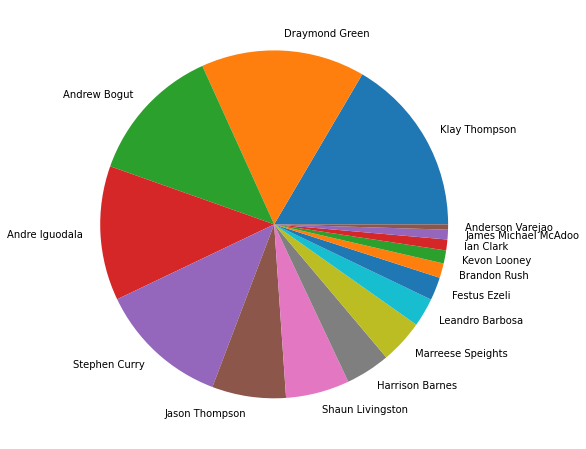

In [36]:
plotTeamSalaries("2015-2016", "Golden State")

This looks more more even than the '93 Bulls but this is mostly on the top end. The overall relative standard deviation is 0.87 for the Warriors but the Bulls are only marginally higher at 0.89. This is the distrubution for the NBA team with the highest regular season win percentage in NBA history, winning 73 out of 82 games. However, this is atypical because Stephen Curry was on a very low-paying contract (only 5th highest on his team) due to past performance and injury trouble, despite being the MVP for the 2015-2016 season.

LA Lakers, 2019-2020, 1.4848159577370332


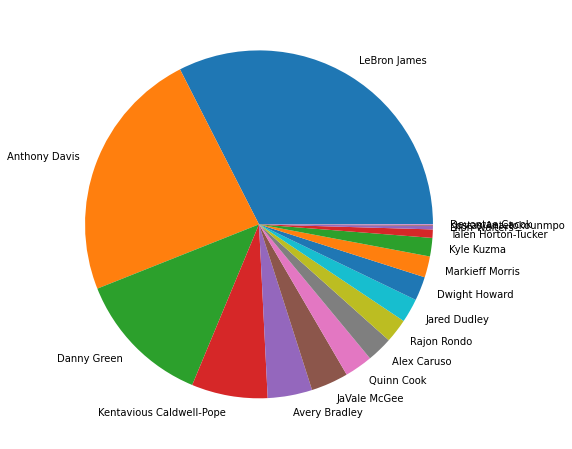

In [37]:
plotTeamSalaries("2019-2020", "LA Lakers")

This example is the most extreme of the one's we've checked, with one player taking over 25% of the entire salary cap and the top 2 taking over 50%. If we want to get more specific and see just what % each player gets we can print and graph the share of the total per player.

In [38]:
def sharePerPlayer(year, team):
    players, salaries = playersAndSalaries(year, team) 
    shares = [x / sum(salaries) for x in salaries]
    return players, shares

def printSharesPerPlayer(year, team):
    players, shares = sharePerPlayer(year, team)
    ps = list(zip(players, shares))
    for p in ps:
        print(p)

In [39]:
printSharesPerPlayer("2019-2020", "LA Lakers")

('LeBron James', 0.3250238407719033)
('Anthony Davis', 0.23521944853080756)
('Danny Green', 0.1270525070335931)
('Kentavious Caldwell-Pope', 0.07066460269624174)
('Avery Bradley', 0.04138671704125552)
('JaVale McGee', 0.03472768369310302)
('Quinn Cook', 0.026045762769827265)
('Alex Caruso', 0.023875282539008325)
('Rajon Rondo', 0.022266982733734262)
('Jared Dudley', 0.022266982733734262)
('Dwight Howard', 0.022266982733734262)
('Markieff Morris', 0.019620160229538875)
('Kyle Kuzma', 0.017143321055100306)
('Talen Horton-Tucker', 0.007799056384587844)
('Dion Waiters', 0.0032590628857838695)
('Kostas Antetokounmpo', 0.0006908030840232053)
('Devontae Cacok', 0.0006908030840232053)


More precisely, we see that Lebron James has 32.5% of the total salary and Anthony Davis has 23.5%, for a total of 56% of the entire salary between the two of them. A bar chart gives us another way to visualize this distribution further:

In [40]:
def plotSalariesPerPlayer(year, team):
    players, salaries = playersAndSalaries(year, team)
    firstNames = [p.split(" ")[0] for p in players]
    plt.bar(firstNames, salaries)

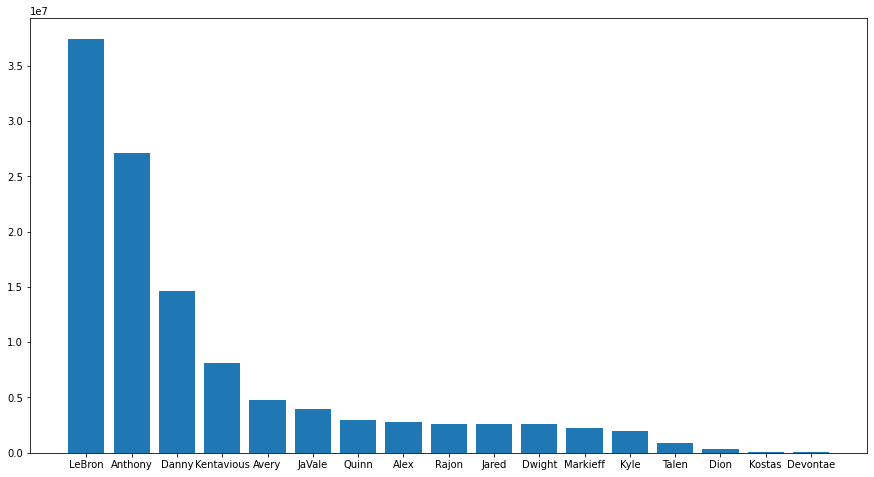

In [41]:
plotSalariesPerPlayer("2019-2020", "LA Lakers")

We can also pick a team at random to generate the bar char and pie graph for.

In [43]:
def getRandYear():
    years = set(df_players.index.get_level_values('year'))
    return random.choice(list(years))

def getRandTeamForYear(year):
    teams = set(df.loc[year].index.get_level_values('team'))
    return random.choice(list(teams))

def allPlotsRandom():
    year = getRandYear()
    team = getRandTeamForYear(year)
    plotTeamSalaries(year, team)
    plotSalariesPerPlayer(year, team)

Sacramento, 2009-2010, 0.9888939123601137


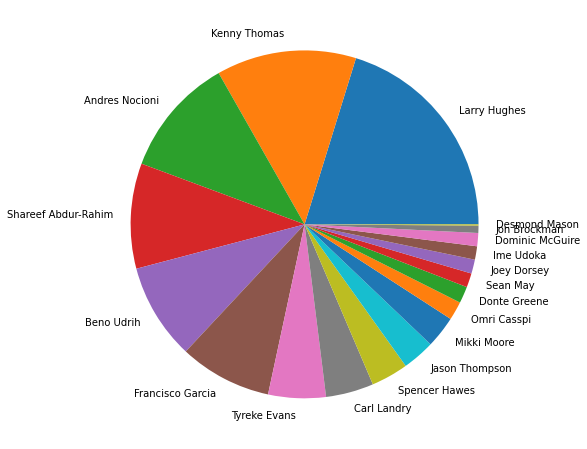

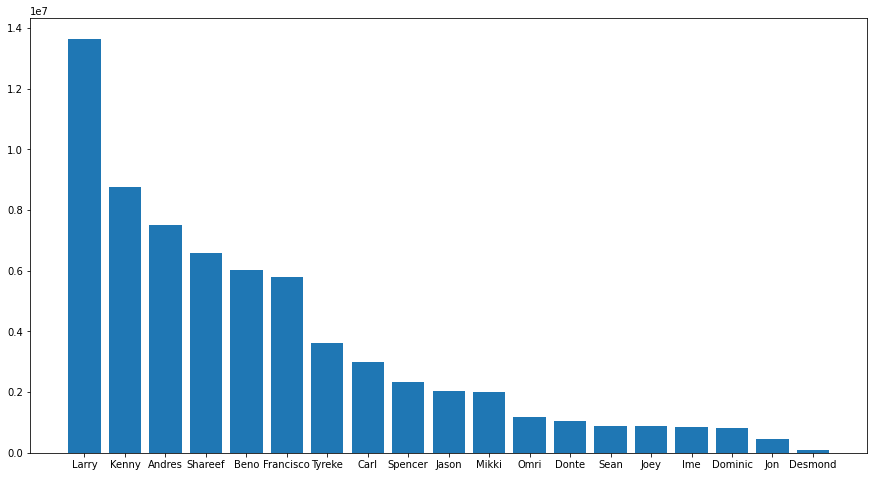

In [44]:
allPlotsRandom()

<a id='spot-checking-conclusions'></a>
### Spot-checking conclusions [top](#top)

We can begin to answer one of our [more open-ended questions](#more-openended-questions): **Do some of the historically signifant teams share similarities in their distribution of salaries?**

The 1992-1993 Bulls and 2015-2016 Golden State warriors had similarly succesful seasons and their distribution of salaries is fairly similar. Yet these teams vary greatly when compared to the the 2019-20 Lakers and 2011-2012 Heat (which are similar to eachother), who have very high concentrations in salaries in a few players and were also very succesful.

Something else interesting to look at could be the distributions of salaries for all the teams that an individual player was on, namely Lebron. It seems like Lebron, and likely other players, may tend to be on teams with a similar salary distribution. We can't attribute this entirely to ability, as we see that Michael Jordan's team (still considered by most to be the greatest player of all-time) is not similar.

<a id='measuring-the-distribution'></a>
## Measuring the Distribution of Salaries [top](#top)

Initially I decided to use the standard deviation to measure how salaries are distributed. The standard deviation represents the degree to which salaries on a team deviate from the mean salary. A larger standard deviation means players salaries are distributed less evenly. However, since total salaries have risen a lot since 1990, the average standard deviation will increase over time simply due to salary increases. This is not what we are interested in. This is why I decided to use the [relative standard deviation, or coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation), which is the standard deviation divided by the mean. This will normalize our salaries so that they can be effectively compared across different periods.

<a id='plotting-the-leagues'></a>
## Plotting the League's Average Distribution Over Time [top](#top)
We can use a line chart to visualize the difference in average relative standard deviation over time.

In [62]:
def yearsAndAvgRsds(df):
    years = list(set(df.index.get_level_values(0)))
    years.sort()
    rsds = df.groupby('year')['salary rsd'].mean().values
    return years, rsds

In [64]:
def plotRsdOverTime(df, team=None):
    temp = df
    # change df if team defined
    if team and team in df.index.levels[1]:
        temp = temp.xs(team, level=1, drop_level=False) 
    years, rsds = yearsAndAvgRsds(temp)
    
    #shorten to start year for graph readability
    years = [y.split("-")[0] for y in years]

    #plot configuration
    title = "Average Relative Standard Deviation of over Time"
    if team:
        title = title + " for " + team
    plt.title(title)
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.plot(years, rsds)
    plt.xlabel("Year")
    plt.ylabel("Average Relative Std. Deviation")
    plt.grid(True)
    plt.show

The year shown on the x-axis below is shortened to the the season's start year for legibility. So '1990' represents the 1990-1991 season. The average relative standard deviation is the average for all teams in the league for the given year. This should either confirm or deny [our main hypothesis](#my-hypotheses): **Team's salaries are less evenly distributed in 2021 than the mid 90's (when I started folliwing the NBA).**

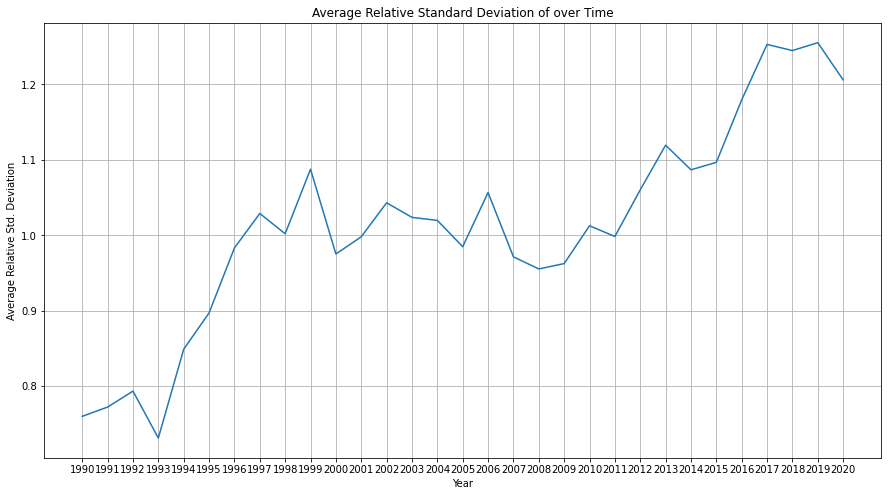

In [65]:
plotRsdOverTime(df_processed)

This graph shows that the original hypothesis was correct - the difference between salaries on teams is getting larger over time. Interestingly, the more recent upwards trend starts aroud the formation of "The Big 3" (Lebron James, Chris Bosh, and Dwayne Wade) in Miami in 2011.This confirms our [follow-up hypothesis](#my-hypotheses) that **this trend coincides with Lebron's move to Miami in 2011**. The formation of the Big-3 is not necessarily a cause, but it is certainly emblamatic of a recent trend.

In addition, RSD increased a lot between 1993 and 1999 before leveling off until about 2012 where we see the hypothesized trend upward to the present year (where it may be leveling off again). It would be interesting to get earlier data and see if there is a plateau leading up to 1993. Similarly, it will be interesting going forward to see if the past few years continue to stay within the same range or breakout in either direction.

We can also plot a specifi team's relative standard deviation over time for one of the listed teams like so:

In [66]:
df.index.levels[1]

Index(['Atlanta', 'Boston', 'Brooklyn', 'Charlotte', 'Chicago', 'Cleveland',
       'Dallas', 'Denver', 'Detroit', 'Golden State', 'Houston', 'Indiana',
       'LA Clippers', 'LA Lakers', 'Memphis', 'Miami', 'Milwaukee',
       'Minnesota', 'New Orleans', 'New York', 'Oklahoma City', 'Orlando',
       'Philadelphia', 'Phoenix', 'Portland', 'Sacramento', 'San Antonio',
       'Toronto', 'Utah', 'Washington'],
      dtype='object', name='team')

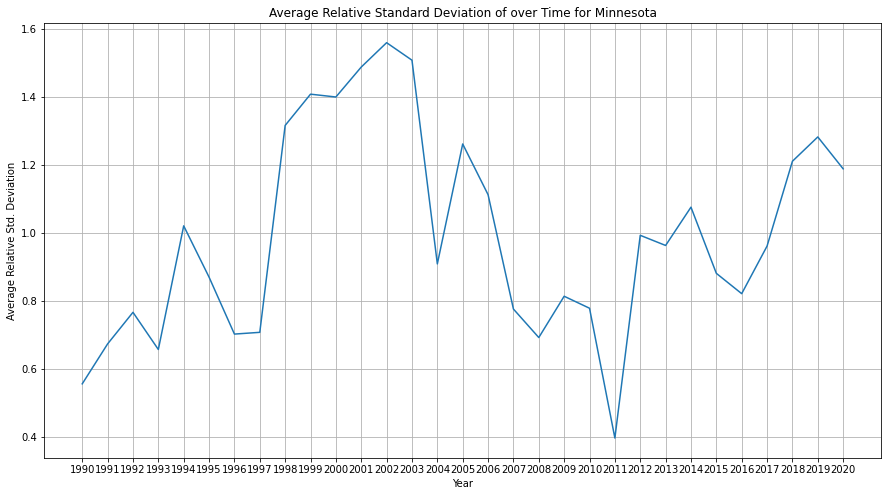

In [68]:
plotRsdOverTime(df_processed, "Minnesota")

<a id='relating-wins-to'></a>
## Relating Wins to Distribution of Salaries [top](#top)

How can we measure correlation? Before answering this we must need know if the data follows a normal distribution as explained in [Jason Brownlee's article on Machine Learning Master](https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/). If it does, we can use something like the Pearson correlation coefficient to test for a linear correlation, otherwise we will need to find a different coefficient, such as [Spearman's correlation coefficient](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr). 

In order to determine if the distribution is normal, we can start by plotting the win percentages and relative standard deviation in a histogram and check them visually.

But before doing this we will need to drop the last year from our dataframe because the win percentages are from a very small sample size of games. This is not a problem for salaries, which are finalized before the season starts, but win percentage data might be very skewed since only a few games have been played at the time of writing this.

In [70]:
df_salary_win_corr = df_processed.drop('2020-2021')
df_salary_win_corr.tail()

salary rsd  win percentage
year      team                                   
2019-2020 Sacramento     0.954650           0.431
          San Antonio    1.265622           0.451
          Toronto        1.374404           0.736
          Utah           1.350119           0.611
          Washington     1.491647           0.347

Now we can visualize how win percentages and relative standard deviations are distributed.

In [72]:
def plotHist(df, column, bins=None, range=None):
    plt.rcParams['figure.figsize'] = [8, 6]
    plt.hist(df[column], bins, range)
    plt.title(f"Distribution of {column}")
    plt.show()

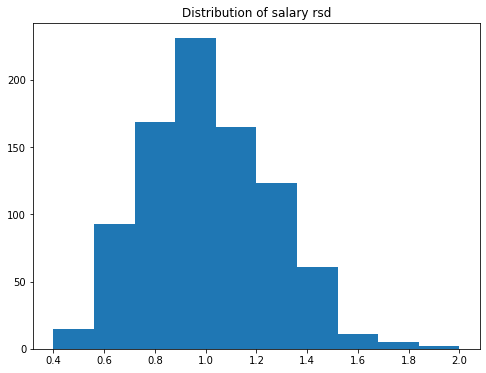

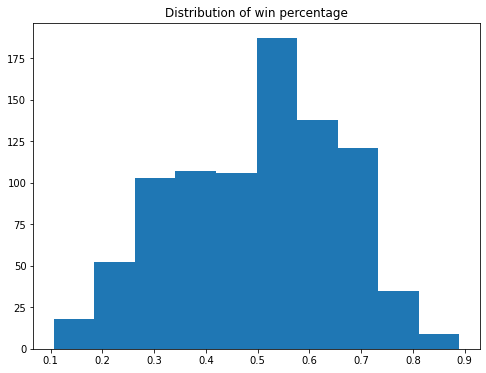

In [73]:
plotHist(df_salary_win_corr, 'salary rsd', 10, (0.4, 2.0))
plotHist(df_salary_win_corr, 'win percentage')

These look roughly normal.

Although our visual check roughly confirms these are a normal distribution, we could use something more quantitative such as the shapiro-Wilk test. We can check the resulting p value to determine if the data likely comes from a normal distribution. A p value of 0.05 means that we cannot reject the hypothesis that the sample data comes from a population with a normal distribution. (https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test)

In [74]:
def printShapiroResults(df, column):
    a = 0.05
    stat, p = shapiro(df[column])
    print(stat, p, f"Passed: {p < a}")

In [76]:
printShapiroResults(df_salary_win_corr, "salary rsd")
printShapiroResults(df_salary_win_corr, "win percentage")

0.9893555045127869 5.5933251132955775e-06 Passed: True
0.9847343564033508 6.427324450442029e-08 Passed: True


Thus, the shapiro tests also suggests that the distribution is normal so we can use Pearson's correlation coefficient.

<a id='correlation-of-win'></a>
## Correlation of Win Percentage and Relative Standard Deviation [top](#top)

Pearson's correlation coefficient is a number between -1 and 1 that represents the linear correlation between two datasets. -1 represents high negative correlation, 0 represents no linear correlation, and 1 represents a high positive correlation. The `scipy` package returns this value as well as the p value, which is the probability that the observed coefficient could have occurred in a random sample.

In [79]:
correlation, p = pearsonr(df_salary_win_corr['salary rsd'], 
                          df_salary_win_corr['win percentage'])
print(correlation, p)

0.14766427295143592 1.142398358868267e-05


The pearson correlation coefficient for the win percentage and coefficient of variation is 0.148 to 3 d.p and the p value is 0.000011. Although the coefficient indicates there likely isn't a linear correlation, the low p value indicates that it is extremeley unlikely that the coefficient is a result of uncorrelated datasets. There is likely a non-linear correlation. This can be illustrated by comparing a scatterplot of our data with randomized data constrained to the same range.

In [82]:
def plotWinRsd(winp, rsd):
    plt.rcParams['figure.figsize'] = [8, 8]
    plt.scatter(winp, rsd)    
    step = df_salary_win_corr['salary rsd'].max() / 20 # 5% of high 
    plt.axis(xmin=0, xmax=1, 
             ymin=df_salary_win_corr['salary rsd'].min() - step,
             ymax=df_salary_win_corr['salary rsd'].max() + step)
    plt.title("Win Percentage vs. Relative Standard Deviation")
    plt.xlabel("Win Percentage")
    plt.ylabel("Relative Standard Deviation")
    plt.show

<a id='observed-data'></a>
### Observed Data [top](#top)

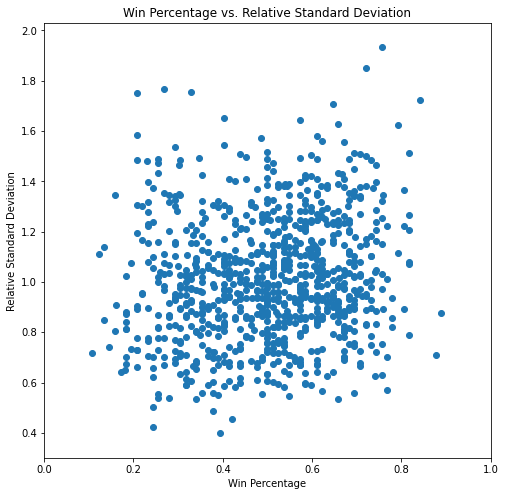

In [84]:
plotWinRsd(df_salary_win_corr['win percentage'],
           df_salary_win_corr['salary rsd'])

<a id='random-data'></a>
### Random Data [top](#top)

In [85]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def randSeriesFrom(series):
    randSeries = get_truncated_normal(mean=series.mean(), 
                               sd=series.std(),
                               low=series.min(), 
                               upp=series.max())
    
    return randSeries.rvs(series.size)

Our data is normally distributed (as shown above), so we are randomizing this data according to a normal distribution. It also has the same standard deviation and upper/lower limits as our real data. This will give us a randomized version of our data.

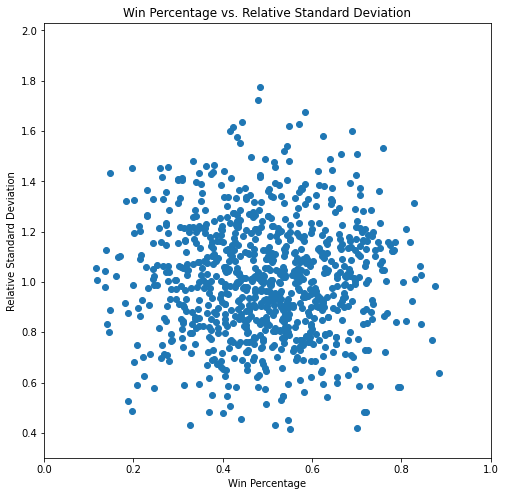

In [89]:
randWinP = randSeriesFrom(df_salary_win_corr['win percentage'])
randRsd = randSeriesFrom(df_salary_win_corr['salary rsd'])
plotWinRsd(randWinP, randRsd)

In [91]:
correlation, p = pearsonr(randRsd, randWinP)
print(correlation, p)

-0.008140019209809215 0.8098786798547651


The correlation coefficient is lower (-0.008 to 3 d.p.) compared to our observed data (0.148 to 3 d.p.) and the p value is higher (0.810 to 3 d.p.) than the observed data (0.000011) as well. This means there is even less linear correlation than our dataset and the probability that it was generated randomly is high. This is somewhat evident in the shape of the plot. We see a circle with with a dense center and limits that are pretty even in their distance from the core. This illustrates how our normally distributed data is different than a random normal distribution.

<a id='further-exploration'></a>
## Further Exploration [top](#top)
I am curious if looking at the extremes for either variables will reveal any patterns. That is, if we take the top 10 percentile teams by wins for each year, will we notice anything about the distribution of relative standard deviations? This question can also be asked about the bottom 10 percentile team by wins, as well as the top/bottom 10 percentile team by relative standard deviation.

To get the top and bottom percentile teams we can sort by win percentage, group by year, and then take the first/last 3 teams (roughly 30 teams each year).

In [92]:
df_bottom_win = (df_salary_win_corr
                 .sort_values("win percentage")
                 .groupby("year", as_index=False)
                 .head(3))
df_top_win = (df_salary_win_corr
              .sort_values("win percentage")
              .groupby("year", as_index=False)
              .tail(3))

For example, we can get the bottom 3 teams by winning percentage from 1990-1991 like so:

In [93]:
df_bottom_win.loc["1990-1991"]

,salary rsd,win percentage
team,,
Denver,0.702283,0.244
Miami,0.927880,0.293
Sacramento,0.947356,0.305


Now we can plot them. The orange dots are the top 10 percentile by win percentage and the blue dots are the bottom 10 percentile.

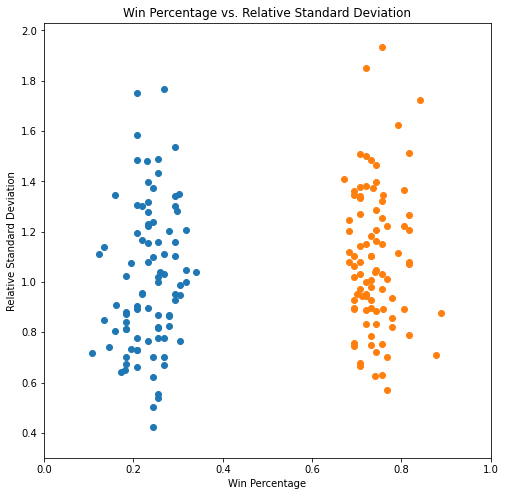

In [96]:
plotWinRsd(df_bottom_win['win percentage'], 
           df_bottom_win['salary rsd'])
plotWinRsd(df_top_win['win percentage'], 
           df_top_win['salary rsd'])

This doesn't tell us too much. The top 10 percentile by wins seem to have a few more extreme high relative standard deviations, and the bottom 10 percentile seems to have a few more extreme lows, but these amounts are probably insignificant. Other than these extremes, it seems the cluster on the right (top 10 percentile) are clustered a bit tighter than the left side (bottom 10 percentile). 

Since we already know we're dealing with the highest and lowest winning teams, it's of limited value to plot the win percentage dimension. We can ignore this axis and just plot the distribution of relative standard deviations in a histogram for both the top and bottom 10 percentile.

This draws from the bottom 10 percentile of teams for each year and shows the distribution of salaries amongst them.

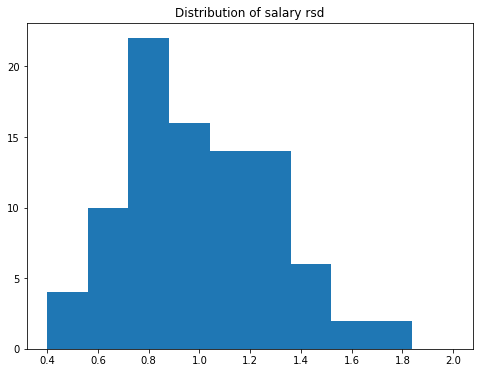

In [97]:
plotHist(df_bottom_win, 'salary rsd', 10, (0.4, 2.0))

This draws from the top 10 percentile of teams for each year and shows the distribution of salaries amongst them.

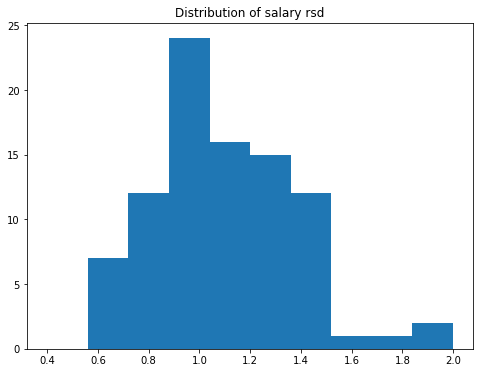

In [99]:
plotHist(df_top_win, 'salary rsd', 10, (0.4, 2.0))

We see the extreme ends differ and the top 10 percentile is a little less spread out, as we noted from the scatterplot, but the histograms don't reveal much else of note.

Similarly, we can look at the top/bottom 10 percentile of teams per year by the relative standard deviation. This time we just need to sort by `salary rsd` before applying the saming grouping.

In [100]:
df_bottom_salary = (df_salary_win_corr
                    .sort_values("salary rsd")
                    .groupby("year", as_index=False)
                    .head(3))
df_top_salary = (df_salary_win_corr
                 .sort_values("salary rsd")
                 .groupby("year", as_index=False)
                 .tail(3))

So we can get the top 10 percentile of relative standard devations for the most recently completed season like so:

In [102]:
df_top_salary.loc["2019-2020"]

,salary rsd,win percentage
team,,
Washington,1.491647,0.347
Brooklyn,1.570608,0.486
Houston,1.580495,0.611


Now let's plot all of them. The orange dots are the top 10 percentile by relative standard deviation and the blue dots are the bottom 10 percentile.

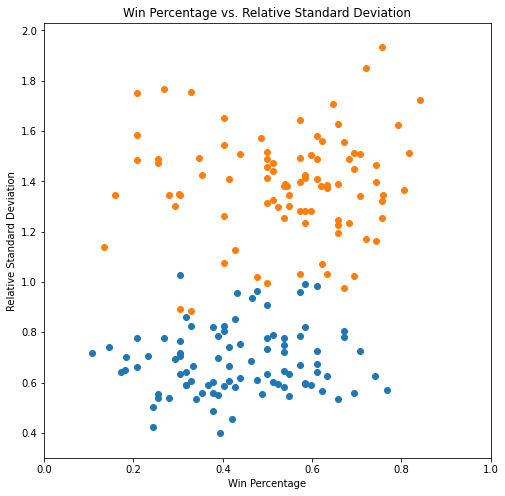

In [103]:
plotWinRsd(df_bottom_salary['win percentage'], 
           df_bottom_salary['salary rsd'])
plotWinRsd(df_top_salary['win percentage'], 
           df_top_salary['salary rsd'])

What we care about here is horizontal dimmension. We see the overall range is pretty looks pretty similar. One of the more interesting things to note is that there is crossover between the top and bottom percentiles. That is, some years' teams with the lowest relative standard deviation were higher than the teams with the highest relative standard deviations. This probably shouldn't suprise us too much since we learned earlier that the average relative standard deviation per year has been on the rise.

We can look at the histogram for these percentiles as well. This first histogram shows win percentages for the bottom 10 percentile teams per year by relative standard deviation.

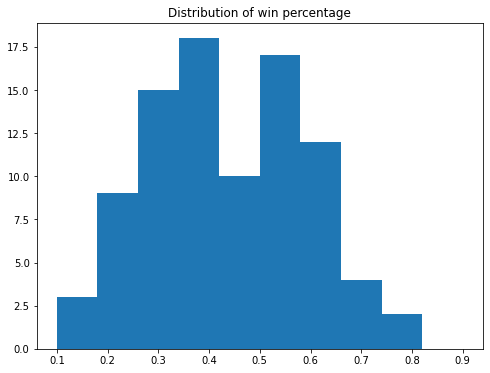

In [105]:
plotHist(df_bottom_salary, 'win percentage', 10, (0.1, 0.9))

This is a fairly normal looking distribution with similar extremes and most win perventages falling in the middle.

Now lets look at the top 10 percentile of teams per year by relative standard deviation.

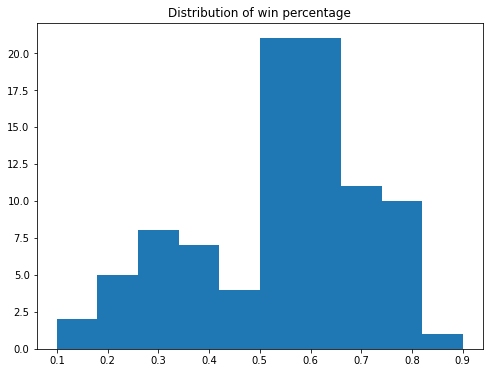

In [107]:
plotHist(df_top_salary, 'win percentage', 10, (0.1, 0.9))

This one is more interesting - we see that the teams who have more disparite salaries than other teams in the league that year perform better than the average team. The average win percentage is extremely close since teams normally play the same number of games, and a win for 1 team means loss for the other. We can see this here:

In [109]:
df_processed["win percentage"].mean()

0.49961589403973516

<a id='correlation-conclusions'></a>
### Correlation Conclusions [top](#top)

Overall, these results are inconclusive. It is clear that there is not a linear relationship between relative standard deviation of salaries and win percentage. Yet the relationship doesn't appear to be random and the teams with the highest relative standard deviations each year had above-average winning percentages. So to answer the first of our [more open-ended questions](#more-openended-questions): **Does this strategy work?** Maybe a little.

<a id='measuring-correlation-over'></a>
## Measuring Correlation Over Time [top](#top)
So far we have aggregated all win and relative standard deviation data and tried to identify a correlatoin. Since we saw that the relative standard deviation has trended upward over time, it's possible the correlation coefficient has change as well. Perhaps there is a clear trend in one direction or another. This will answer the last of our [more open-ended questions](#more-openended-questions) I posed at the beginning: **Has this strategy's effectiveness been consistent or changed over time?**

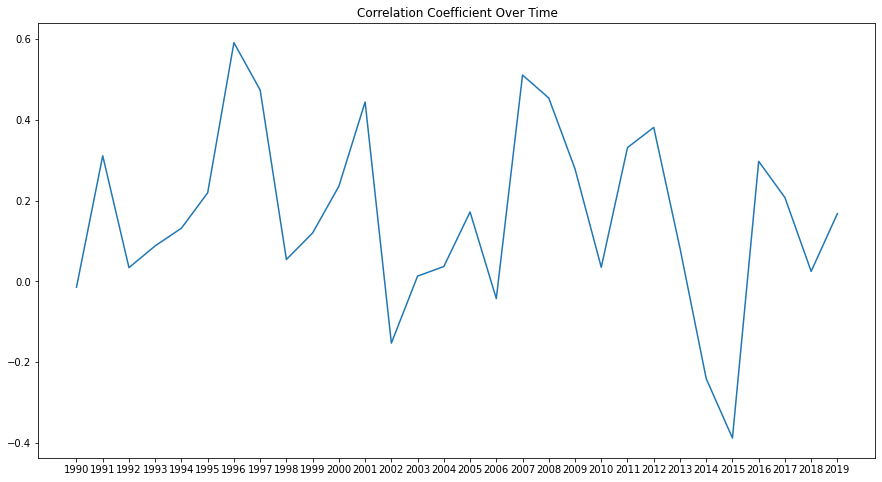

In [111]:
df_yearly_corr = (df_salary_win_corr
                  .groupby('year')['salary rsd']
                  .corr(df_salary_win_corr['win percentage']))
plt.rcParams['figure.figsize'] = [15, 8]
years = [x.split("-")[0] for x in df_yearly_corr.index]
plt.plot(years, df_yearly_corr.values)
plt.title("Correlation Coefficient Over Time")
plt.show()

The graph shows that the coefficient has bounced around over time (ranging from ~0.6 to ~-0.4) but appears to trend around the ~0.15 coefficient we saw in aggregate. It does not appear to trend one way or another.

We can pick out the most extreme years in either direction to see what they look like graphed with a linear regression line.

In [112]:
def plotScatterLine(df, year):
    x = df.loc[(year)]['win percentage']
    y = df.loc[(year)]['salary rsd']
    plotWinRsd(x, y)
    res = linregress(x, y)
    plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')

First, the lowest correlation which occurred inin 2015-2016: ~-0.4

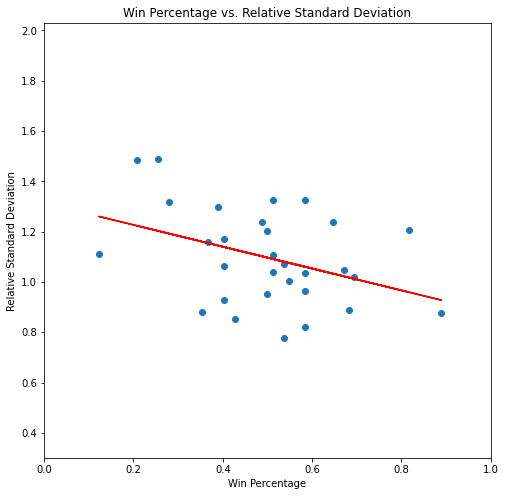

In [114]:
plotScatterLine(df_salary_win_corr, '2015-2016')

Next, the highest correlation which occurred in 1996-1997: ~0.6

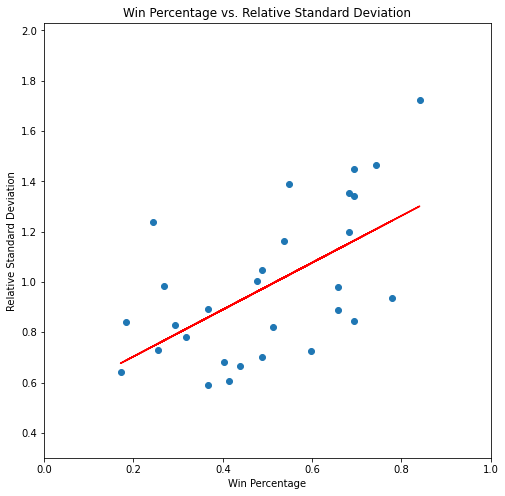

In [115]:
plotScatterLine(df_salary_win_corr, '1996-1997')

<a id='conclusions'></a>
# Conclusions [top](#top)

<a id='results'></a>
### Results [top](#top)
To recap, we hypothesized that salaries have become less evenly distributed over time, and that this trend started around the time Lebron moved to the Heat. Both of these were proven true, and we also learned that a similar upward trend occured in the mid 90's.

We did not get a definitive answer for how the uneven distribution of salaries correlates to success. We saw that the teams with the most disparite salaries each year did better than average, but there was not a linear correlation overall.

<a id='suggestions-for-future'></a>
### Suggestions for  future direction [top](#top)
In the Washington Post article entitled ["Big Threes are out, Big Twos are in, and the NBA is the most balanced it’s been in years"](https://www.washingtonpost.com/sports/2019/10/21/big-threes-are-out-big-twos-are-nba-is-most-balanced-its-been-years/), Ben Golliver suggests that we are moving away from on "Big Threes" to "Big Twos". It would be interesting to test this claim with the data that we have. This also suggests that we may be able to measure the allocation of salaries differently. Instead of using the relative standard deviation we could use the percentage allocated to n-players (such as 2, or 3). This could be measured over time and correlated to win percentage like we did with the relative standard deviations.

We could also try to measure success differently. While regular season win percentage should be a fairly good indicator, it's not the best way to determine who is the very best team. Often teams will hold back in the regular season in anticipation of the playoffs. With 7 game playoff series, the best teams nearly always advance. The API I used does not have this information readily available but parsing playoff game history to determine final rankings might be worth it to give us another perspective on success.

<a id='what-i-would'></a>
### What I would do differently [top](#top)
One thing I would do differently is the storage of the data I collected. Originally JSON made sense to me because of how I thought about the data: Every year has teams, and each of these teams has players, and players have salaries. This is how I arrived at the nested structure. I also wasn't nearly as familiar with pandas as I am now. If I were to start over I would use a csv file instead which would flatten all my data out like so:

```
YEAR, TEAM, PLAYER, SALARY, WINPCT
year1, team1, player1, s1, w1
year1, team1, player2, s2, w1
```

Then I could more easily load it into a pandas dataframe and use `groupby()` and `MultiIndex` to deal with the different levels like I had to do anyways.

<a id='appendix'></a>
# Appendix [top](#top)

<a id='data-sources'></a>
## Data sources [top](#top)
- https://hoopshype.com/salaries/ for team, player, and salary records
- An unofficial API for https://www.nba.com/stats/, maintained here https://github.com/swar/nba_api

<a id='git-history'></a>
## Git history [top](#top)

I used git and github for version control of this project. The git history can be seen here:

In [118]:
!git log --oneline --decorate --graph --all

* 0cf956e (HEAD -> make-presentable, origin/main, main) removed, didnt work
* 079439c moved load function to part2
* f4aafa8 (refs/original/refs/heads/main) added note about soups
* 48a3403 removed unzipped soups from git repo
* bea35e1 small tweaks
* 985194b linguist-detectable=false for html
* 29bb867 added conclusion and appendix
* 3123431 requirements added
* d888703 updated data
* 2c49acf directory structure changes and refactor
* 06d0508 no longer holds rel std dev
* 35087a3 removed dirs during refactor
* c68259f major refactor
* bf5025d added soup backup
* b111794 added relStdDev and winPct
* 5b043b4 added details on sources
* 1a670f1 added file
* d1cbd24 changed file structure
* 0be867a added backup
* c38081a modularized and added more data and analysis
* f80ef0e init commit
